In [1]:
import pandas as pd
import numpy as np

import vaex as vx
import seaborn as sns

import matplotlib.pyplot as plt

import geopandas as gp
import geoplot as gplt

import contextily as cx

In [2]:
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True, connected=True)

In [5]:
from pathlib import Path

DATA_PATH = Path("./DATA/")


# Path with gbif metadata file for plantNaturalist500k
GBIF_METADATA_PATH = DATA_PATH / "plantNaturalist500k.gbif.metadata.csv"
assert GBIF_METADATA_PATH.exists()

# Dir with train/test/split csvs of PlantNet and old-iNat300k
PLANTNET_DS_DIR = DATA_PATH

OUTPUT_PATH = Path("./inat500kplots/")
OUTPUT_PATH.mkdir(exist_ok=True, parents=True)

In [6]:
# Dir containing train/test/split CSV of plantnet dataset species groupby, read the plantnet files for Lorenz curve
"""
kingdom,phylum,class,order,family,genus,species,0
Plantae,Tracheophyta,Cycadopsida,Cycadales,Zamiaceae,Macrozamia,Macrozamia moorei,6
"""
pnet_files = [
    x for x in list(Path(PLANTNET_DS_DIR).resolve().iterdir()) if "plantnet-" in str(x)
]
assert len(pnet_files) == 3

In [21]:
# Whether to use the full or small dataset when doing graphs!
USE_FULL = False
USE_FULL = True

# if USE_FULL=False, will use smaller ds with this many instances
NUM_IN_SMALL_DF = 4000

# PDF for nice latex-ing later on
# but becomes hard for plots with many dots (worldwide distribution)
PLOTS_EXT = "pdf"

In [8]:
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["figure.dpi"] = 100

In [12]:
%load_ext jupyter_black
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

In [10]:
df = pd.read_csv(GBIF_METADATA_PATH)

/tmp/ipykernel_4162031/3353440056.py:1: DtypeWarning: Columns (83,84,85) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(GBIF_METADATA_PATH)


In [11]:
df.head()

key                            datasetKey  \
0  1848759693  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
1  3109319035  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
2  3337481528  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
3  3337507462  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
4  3337791872  50c9509d-22c7-4a22-a47d-8c48425ef4a7   

                       publishingOrgKey                       installationKey  \
0  28eb1a3f-1c15-4a95-931a-4af90ecb574d  997448a8-f762-11e1-a439-00145eb45e9a   
1  28eb1a3f-1c15-4a95-931a-4af90ecb574d  997448a8-f762-11e1-a439-00145eb45e9a   
2  28eb1a3f-1c15-4a95-931a-4af90ecb574d  997448a8-f762-11e1-a439-00145eb45e9a   
3  28eb1a3f-1c15-4a95-931a-4af90ecb574d  997448a8-f762-11e1-a439-00145eb45e9a   
4  28eb1a3f-1c15-4a95-931a-4af90ecb574d  997448a8-f762-11e1-a439-00145eb45e9a   

                 hostingOrganizationKey publishingCountry     protocol  \
0  28eb1a3f-1c15-4a95-931a-4af90ecb574d                US  DWC_ARCHIVE   
1  28eb1a3f-1c15-4a95-931a-4af90ecb574d                US  DWC_ARCHIVE   
2  28eb1a3f-1c15-4a95-931a-4af90ecb574d                AU  DWC_ARCHIVE   
3  28eb1a3f-1c15-4a95-931a-4af90ecb574d                AU  DWC_ARCHIVE   
4  28eb1a3f-1c15-4a95-931a-4af90ecb574d                US  DWC_ARCHIVE   

                     lastCrawled                     lastParsed  crawlId  ...  \
0  2023-12-18T23:28:16.763+00:00  2023-12-19T07:54:52.393+00:00      420  ...   
1  2023-12-18T23:28:16.763+00:00  2023-12-19T08:25:53.109+00:00      420  ...   
2  2023-12-18T23:28:16.763+00:00  2023-12-19T07:41:48.761+00:00      420  ...   
3  2023-12-18T23:28:16.763+00:00  2023-12-19T07:40:28.637+00:00      420  ...   
4  2023-12-18T23:28:16.763+00:00  2023-12-19T08:27:12.852+00:00      420  ...   

        eventTime http://unknown.org/captive identificationID  \
0  14:20:00-04:00                       wild       28058378.0   
1  09:26:00+10:00                       wild      168193338.0   
2  03:23:00+10:00                       wild      177890001.0   
3  13:51:33+13:00                       wild      149862041.0   
4  11:00:00-04:00                       wild      199531165.0   

   occurrenceRemarks  informationWithheld  stateProvince  \
0                NaN                  NaN            NaN   
1                NaN                  NaN            NaN   
2                NaN                  NaN            NaN   
3                NaN                  NaN            NaN   
4                NaN                  NaN            NaN   

   identificationRemarks  infraspecificEpithet  sex  reproductiveCondition  
0                    NaN                   NaN  NaN                    NaN  
1                    NaN                   NaN  NaN                    NaN  
2                    NaN                   NaN  NaN                    NaN  
3                    NaN                   NaN  NaN                    NaN  
4                    NaN                   NaN  NaN                    NaN  

[5 rows x 86 columns]

In [13]:
df.columns

Index(['key', 'datasetKey', 'publishingOrgKey', 'installationKey',
       'hostingOrganizationKey', 'publishingCountry', 'protocol',
       'lastCrawled', 'lastParsed', 'crawlId', 'extensions', 'basisOfRecord',
       'occurrenceStatus', 'taxonKey', 'kingdomKey', 'phylumKey', 'classKey',
       'orderKey', 'familyKey', 'genusKey', 'speciesKey', 'acceptedTaxonKey',
       'scientificName', 'acceptedScientificName', 'kingdom', 'phylum',
       'order', 'family', 'genus', 'species', 'genericName', 'specificEpithet',
       'taxonRank', 'taxonomicStatus', 'iucnRedListCategory', 'dateIdentified',
       'decimalLatitude', 'decimalLongitude', 'coordinateUncertaintyInMeters',
       'continent', 'gadm', 'distanceFromCentroidInMeters', 'year', 'month',
       'day', 'eventDate', 'issues', 'modified', 'lastInterpreted',
       'references', 'license', 'identifiers', 'media', 'facts', 'relations',
       'isInCluster', 'datasetName', 'recordedBy', 'identifiedBy',
       'geodeticDatum', 'class',

In [14]:
INTERESTING_COLUMNS = [
    "key",
    "datasetKey",
    "publishingCountry",
    "taxonKey",
    "kingdomKey",
    "phylumKey",
    "classKey",
    "orderKey",
    "familyKey",
    "genusKey",
    "speciesKey",
    "acceptedTaxonKey",
    "scientificName",
    "acceptedScientificName",
    "kingdom",
    "phylum",
    "order",
    "family",
    "genus",
    "species",
    "genericName",
    "specificEpithet",
    "taxonRank",
    "taxonomicStatus",
    "iucnRedListCategory",
    "decimalLatitude",
    "decimalLongitude",
    "continent",
    # "year",
    # "month",
    # "day",
    # "eventDate",
    "issues",
    "references",
    "license",
    "identifiers",
    "media",
    "facts",
    "relations",
    "isInCluster",
    "datasetName",
    "recordedBy",
    "identifiedBy",
    "geodeticDatum",
    "class",
    "countryCode",
    "recordedByIDs",
    "identifiedByIDs",
    "country",
    "rightsHolder",
    "identifier",
    "http://unknown.org/nick",
    "verbatimEventDate",
    "gbifID",
    "verbatimLocality",
    # "collectionCode",
    "occurrenceID",
    "taxonID",
    "catalogNumber",
    "institutionCode",
    "eventTime",
    "http://unknown.org/captive",
    "identificationID",
    "occurrenceRemarks",
    "informationWithheld",
    "stateProvince",
    "identificationRemarks",
    "infraspecificEpithet",
    "sex",
    "reproductiveCondition",
]

## Basic analysis

In [15]:
# check that we have indeed only tracheophyta
assert df["phylum"].describe()["unique"] == 1

# check that we have at least 10 occurrences for each species (download script ignoring pictures magic)
dfg = df.groupby("speciesKey")["key"].count()
if len(dfg[dfg < 10]):
    raise ValueError("Species with less than 10 occurrences present!")

## Plot worldmap

In [16]:
# df.decimalLatitude, df.decimalLongitude

In [17]:
# We'll project everything to this CRS so cx etc. can talk to each other
DEFAULT_CRS = "EPSG:4326"
# DEFAULT_GEOM_CRS = "EPSG:3035"

In [22]:
# smaller DF
sdf = df.sample(NUM_IN_SMALL_DF)

if USE_FULL:
    DATA = df
else:
    DATA = sdf

pdf = gp.GeoDataFrame(
    DATA,
    geometry=gp.points_from_xy(DATA.decimalLongitude, DATA.decimalLatitude),
    crs="EPSG:4326",
)

# small geo-pandas thnig
GEODF = pdf

In [23]:
# sns.scatterplot(data=DATA, y='decimalLatitude', x='decimalLongitude')
# pdf.plot()

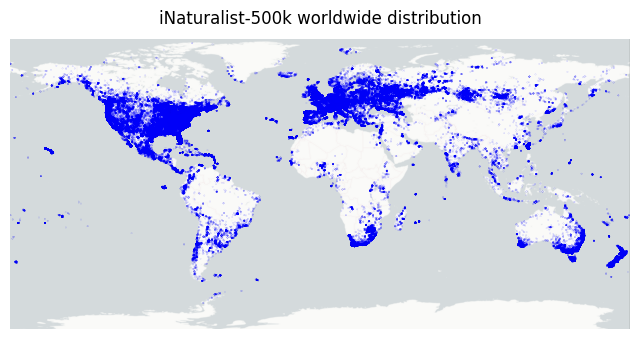

In [24]:
# not working anymore!
# PROVIDER = cx.providers.Stamen.TonerLite
# PROVIDER = cx.providers.Stamen.TonerLines
# PROVIDER = cx.providers.Stamen.Watercolor
# not existing?..
# PROVIDER = cx.providers.OpenStreetMap.BlackAndWhite
# paid
# PROVIDER = cx.providers.Stadia.OSMBright

PROVIDER = cx.providers.OpenStreetMap.Mapnik
PROVIDER = cx.providers.CartoDB.Positron
# nice!
PROVIDER = cx.providers.CartoDB.PositronNoLabels

gdata = GEODF  # [~GEODF.continent.isna()]

ax = gplt.pointplot(
    gdata.to_crs(DEFAULT_CRS),
    color="blue",
    # hue="continent",
    s=0.05,
)

ax.set_title("iNaturalist-500k worldwide distribution")
cx.add_basemap(
    ax,
    source=PROVIDER,
    crs=DEFAULT_CRS,
    attribution=False,
)

ax.figure.savefig(
    OUTPUT_PATH / f"inat500k_worldwide_distribution.{PLOTS_EXT}", bbox_inches="tight"
)

## Sunburst diag

In [25]:
gb_tax = (
    df.groupby(["phylum", "class", "order", "family", "genus", "species"])["key"]
    .count()
    .reset_index()
)
gb_tax

phylum           class        order        family       genus  \
0     Tracheophyta     Cycadopsida    Cycadales    Cycadaceae       Cycas   
1     Tracheophyta     Cycadopsida    Cycadales     Zamiaceae  Macrozamia   
2     Tracheophyta     Cycadopsida    Cycadales     Zamiaceae       Zamia   
3     Tracheophyta      Gnetopsida   Ephedrales   Ephedraceae     Ephedra   
4     Tracheophyta      Gnetopsida   Ephedrales   Ephedraceae     Ephedra   
...            ...             ...          ...           ...         ...   
2486  Tracheophyta  Polypodiopsida  Salviniales  Marsileaceae    Marsilea   
2487  Tracheophyta  Polypodiopsida  Salviniales  Salviniaceae      Azolla   
2488  Tracheophyta  Polypodiopsida  Salviniales  Salviniaceae      Azolla   
2489  Tracheophyta  Polypodiopsida  Salviniales  Salviniaceae    Salvinia   
2490  Tracheophyta  Polypodiopsida  Schizaeales  Schizaeaceae    Schizaea   

                         species  key  
0                   Cycas glauca   14  
1     Macrozamia pauli-guilielmi  192  
2                    Zamia erosa   43  
3            Ephedra nebrodensis   31  
4              Ephedra torreyana  181  
...                          ...  ...  
2486             Marsilea mutica   16  
2487         Azolla filiculoides   13  
2488              Azolla pinnata   40  
2489          Salvinia cucullata   11  
2490          Schizaea dichotoma   97  

[2491 rows x 7 columns]

In [26]:
import plotly.io as pio
import plotly.express as px

pio.renderers.default = "colab"  # or 'colab' or 'iframe'

In [28]:
data = gb_tax

tax_path = ["phylum", "class", "order", "family"]

fig = px.sunburst(
    data,
    path=tax_path,
    # path=["class", "order", "family", "species"],
    values="key",
    color="order",
    # hover_data=["iso_alpha"],
    # color_continuous_scale="RdBu",
    # color_continuous_midpoint=np.average(df["lifeExp"], weights=df["pop"]),
)
fig.show()

fig.write_image(OUTPUT_PATH / f"sunburst_{'-'.join(tax_path)}.{PLOTS_EXT}")

## Lorenz plot

In [29]:
# Get plantnet dataset
dptr = pd.read_csv(pnet_files[2])
dpva = pd.read_csv(pnet_files[1])
dpte = pd.read_csv(pnet_files[0])
d_pnet = pd.concat([dptr, dpva, dpte], ignore_index=True)

In [30]:
gb_tax.groupby("species").sum()

key
species                   
Abelia chinensis        36
Abrus precatorius       24
Abutilon dugesii        16
Abutilon indicum        15
Acacia auriculiformis   58
...                    ...
Zephyranthes concolor   31
Zilla spinosa           15
Zizania texana          51
Zizia aptera           533
Zostera muelleri        12

[2491 rows x 1 columns]

In [31]:
# https://zhiyzuo.github.io/Plot-Lorenz/

# inat - full
# X = ditr["0"]
X = gb_tax.groupby("species").sum()["key"]
X = X.sort_values().values


X_lorenz = X.cumsum() / X.sum()
X_lorenz = np.insert(X_lorenz, 0, 0)
X_lorenz[0], X_lorenz[-1]


# plantnet - entire dataset
# Y = dptr["0"]
Y = d_pnet.groupby("label").sum()["0"]
Y = Y.sort_values().values

Y_lorenz = Y.cumsum() / Y.sum()
Y_lorenz = np.insert(Y_lorenz, 0, 0)
Y_lorenz[0], Y_lorenz[-1]

X_x = np.arange(X_lorenz.size) / (X_lorenz.size - 1)
Y_x = np.arange(Y_lorenz.size) / (Y_lorenz.size - 1)

X_lorenz *= 100
Y_lorenz *= 100
X_x *= 100
Y_x *= 100

/tmp/ipykernel_4162031/1109611054.py:39: UserWarning:

FixedFormatter should only be used together with FixedLocator

/tmp/ipykernel_4162031/1109611054.py:41: UserWarning:

FixedFormatter should only be used together with FixedLocator



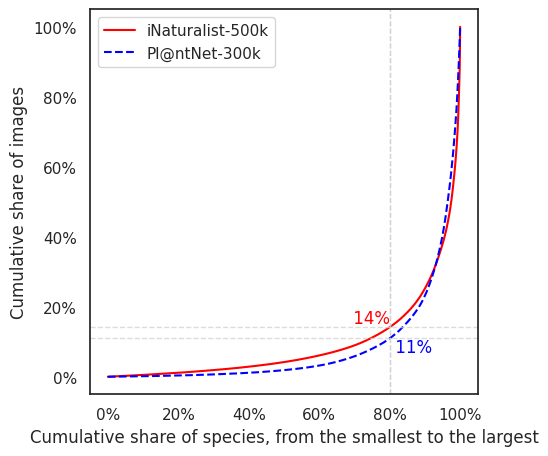

In [32]:
sns.set_context("notebook")

# with sns.axes_style("whitegrid"):
with sns.axes_style("white"):
    # inat
    ax = sns.lineplot(x=X_x, y=X_lorenz, c="red", label="iNaturalist-500k")
    # plantent
    sns.lineplot(
        x=Y_x, y=Y_lorenz, ax=ax, c="blue", linestyle="--", label="Pl@ntNet-300k"
    )

    ax.figure.set_size_inches(5, 5)
    ax.set_xlabel("Cumulative share of species, from the smallest to the largest")
    ax.set_ylabel("Cumulative share of images")

    # https://stackoverflow.com/questions/65622776/how-to-find-x-value-on-a-intersection-point-of-axhline-on-seaborn-ecdf-plot

    x_special = 80
    for line in ax.get_lines():
        x, y = line.get_data()
        ind = np.argwhere(x >= x_special)[
            0, 0
        ]  # first index where y is larger than y_special
        # x[ind] is the desired x-value
        color = line.get_color()
        ax.text(
            x_special,
            y[ind],
            f" {y[ind]:.0f}%",
            ha="left" if color == "blue" else "right",
            va="top" if color == "blue" else "bottom",
            color=color,
            fontsize="medium",
        )  # maybe color=line.get_color()
        ax.axvline(x_special, linestyle="--", color="#cfcfcf", lw=1, alpha=0.75)
        ax.axhline(y[ind], linestyle="--", color="#cfcfcf", lw=1, alpha=0.75)

    x_labels = [f"{item:.0f}%" for item in ax.get_xticks().tolist()]
    ax.set_xticklabels(x_labels)
    y_labels = [f"{item:.0f}%" for item in ax.get_yticks().tolist()]
    ax.set_yticklabels(y_labels)

ax.figure.savefig(OUTPUT_PATH / f"lorenz_inat_pnet.{PLOTS_EXT}", bbox_inches="tight")

In [189]:
pd.json_normalize(df.iloc[:100].media).iloc[

Loading... (need help?)


In [210]:
m = df.iloc[1:43].media.apply(eval)
m

media
Loading... (need help?)


In [211]:
pd.json_normalize(m).

0  \
0   {'type': 'StillImage', 'format': 'image/jpeg',...   
1   {'type': 'StillImage', 'format': 'image/jpeg',...   
2   {'type': 'StillImage', 'format': 'image/jpeg',...   
3   {'type': 'StillImage', 'format': 'image/jpeg',...   
4   {'type': 'StillImage', 'format': 'image/jpeg',...   
5   {'type': 'StillImage', 'format': 'image/jpeg',...   
6   {'type': 'StillImage', 'format': 'image/jpeg',...   
7   {'type': 'StillImage', 'format': 'image/jpeg',...   
8   {'type': 'StillImage', 'format': 'image/jpeg',...   
9   {'type': 'StillImage', 'format': 'image/jpeg',...   
10  {'type': 'StillImage', 'format': 'image/jpeg',...   
11  {'type': 'StillImage', 'format': 'image/jpeg',...   
12  {'type': 'StillImage', 'format': 'image/jpeg',...   
13  {'type': 'StillImage', 'format': 'image/jpeg',...   
14  {'type': 'StillImage', 'format': 'image/jpeg',...   
15  {'type': 'StillImage', 'format': 'image/jpeg',...   
16  {'type': 'StillImage', 'format': 'image/jpeg',...   
17  {'type': 'StillImage', 'format': 'image/jpeg',...   
18  {'type': 'StillImage', 'format': 'image/jpeg',...   
19  {'type': 'StillImage', 'format': 'image/jpeg',...   
20  {'type': 'StillImage', 'format': 'image/jpeg',...   
21  {'type': 'StillImage', 'format': 'image/jpeg',...   
22  {'type': 'StillImage', 'format': 'image/jpeg',...   
23  {'type': 'StillImage', 'format': 'image/jpeg',...   
24  {'type': 'StillImage', 'format': 'image/jpeg',...   
25  {'type': 'StillImage', 'format': 'image/jpeg',...   
26  {'type': 'StillImage', 'format': 'image/jpeg',...   
27  {'type': 'StillImage', 'format': 'image/jpeg',...   
28  {'type': 'StillImage', 'format': 'image/jpeg',...   
29  {'type': 'StillImage', 'format': 'image/jpeg',...   
30  {'type': 'StillImage', 'format': 'image/jpeg',...   
31  {'type': 'StillImage', 'format': 'image/jpeg',...   
32  {'type': 'StillImage', 'format': 'image/jpeg',...   
33  {'type': 'StillImage', 'format': 'image/jpeg',...   
34  {'type': 'StillImage', 'format': 'image/jpeg',...   
35  {'type': 'StillImage', 'format': 'image/jpeg',...   
36  {'type': 'StillImage', 'format': 'image/jpeg',...   
37  {'type': 'StillImage', 'format': 'image/jpeg',...   
38  {'type': 'StillImage', 'format': 'image/jpeg',...   
39  {'type': 'StillImage', 'format': 'image/jpeg',...   
40  {'type': 'StillImage', 'format': 'image/jpeg',...   
41  {'type': 'StillImage', 'format': 'image/jpeg',...   

                                                    1  \
0                                                None   
1                                                None   
2                                                None   
3                                                None   
4                                                None   
5   {'type': 'StillImage', 'format': 'image/jpeg',...   
6                                                None   
7                                                None   
8   {'type': 'StillImage', 'format': 'image/jpeg',...   
9                                                None   
10                                               None   
11                                               None   
12                                               None   
13  {'type': 'StillImage', 'format': 'image/jpeg',...   
14  {'type': 'StillImage', 'format': 'image/jpeg',...   
15                                               None   
16                                               None   
17                                               None   
18                                               None   
19                                               None   
20                                               None   
21                                               None   
22                                               None   
23                                               None   
24                                               None   
25                                               None   
26                                               None   
27  